In [1]:
from load import *
from torch import Tensor, nn
import torch
from model_base import *
from modules import *
from anim import *
import util
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings

ROOT = "./Datas/Week 8"

Q = 1.60217663e-19

In [2]:
sc = load_space_charge() * -Q
ep = load_elec_potential()
vg = load_vgs()
poi = NormalizedPoissonMSE('cpu')
poi(ep, sc)

tensor(5.3032e-10, dtype=torch.float64)

In [14]:
# Pass a function object to scipy because we can avoid closures and local functions
class ReconstructedPoissonLoss:
    def __init__(self, xep, xsc, /, device = None):
        self.i = 0
        self.xep = xep
        self.xsc = xsc
        self.poisson_loss = NormalizedPoissonRMSE(device)
        self._device = self.poisson_loss._device

    def set_i(self, i):
        self.i = i
        return self

    def reconstruct(self, x):
        i = self.i

        ep_region_2 = x[:429].reshape(84 - 45, 11)
        ep_region_5 = x[429:663].reshape(84 - 45, 6)
        sc_region_2 = x[663:].reshape(84 - 45, 11)

        reconstructed_ep = self.xep[i]
        reconstructed_ep[45:84,:11] = ep_region_2
        reconstructed_ep[45:84,11:] = ep_region_5
        reconstructed_ep = reconstructed_ep.reshape(1, 129, 17)

        reconstructed_sc = self.xsc[i]
        reconstructed_sc[45:84,:11] = sc_region_2
        reconstructed_sc = reconstructed_sc.reshape(1, 129, 17)

        return reconstructed_ep, reconstructed_sc
    
    def __call__(self, x):
        x = torch.tensor(x).to(self._device)
        rep, rsc = self.reconstruct(x)
        mse = self.poisson_loss(rep, rsc)
        return float(mse.item())

class DebugeModel(Model):
    """Use a first model to predict stuff, then use a second model to make them self consistent - aka satisfy the Poisson equation"""
    def __init__(self, ep1: TrainedLinear, sc1: TrainedLinear):
        # From the linearity plots, we only need to care about region 2 in practice for space charge
        # and region 2, 5 for electric potential
        self.ep1 = ep1
        self.sc1 = sc1
        
    def forward(self, x) -> Tensor:
        num_data = int(x.shape[0])
        result = torch.zeros(num_data, 4386)

        # Initial prediction
        xep = self.ep1(x).reshape(-1, 129, 17).cpu()
        xsc = self.sc1(x).reshape(-1, 129, 17).cpu()
                
        ep_region_2 = xep[:, 45:84,:11].reshape(-1, 429)
        ep_region_5 = xep[:, 45:84,11:].reshape(-1, 234)
        sc_region_2 = xsc[:, 45:84,:11].reshape(-1, 429)

        joined = torch.cat([ep_region_2, ep_region_5, sc_region_2], dim = 1)

        pca = PrincipalComponentExtractor(1092)
        pca.fit(joined)

        # print(f"eigenvalues: {pca.eigenvalues.cpu().numpy()}")
        # print(f"sum of eigenvalues: {torch.sum(pca.eigenvalues).item()}")
        # print(f"Shape of eigenvector array: {pca.eigenvalues.shape}")

        x_ = pca.project(joined)
        return x_

eigenvalues: [9.62569962e+01 4.84101292e-06 3.93584696e-06 ... 4.75335196e-16
 4.75335196e-16 2.38543457e-16]
sum of eigenvalues: 96.2571572140445
Shape of eigenvector array: torch.Size([1092])


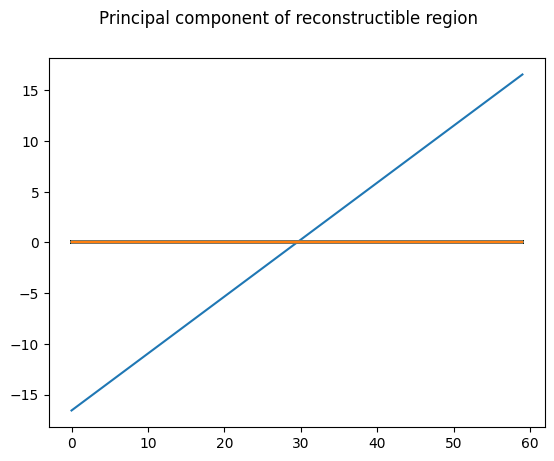

In [29]:
index = util.TRAINING_IDXS["First 60"]

x = vg[index]
epy = ep[index]
scy = sc[index]
ep_linear = TrainedLinear(1, 2193, algorithm='linear').fit(x, epy.reshape(-1, 2193))
sc_linear = TrainedLinear(1, 2193, algorithm='linear').fit(x, scy.reshape(-1, 2193))
model = DebugeModel(ep_linear, sc_linear)
# print(model.summary())

a = model(x).cpu().numpy()[:, :]
fig, ax = plt.subplots()
ax.plot(a)
fig.suptitle("Principal component of reconstructible region")
pass

In [31]:
fig.savefig("Components of something.svg")